## RFM-Analysis


In [55]:
# ! pip install squarify

import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import squarify  
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches  # For custom legend

### Load the dataset

In [56]:
file_path = "rfm_data_orders.csv"  
df = pd.read_csv(file_path)

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4906 entries, 0 to 4905
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   4906 non-null   int64 
 1   customer_id  4906 non-null   object
 2   order_date   4906 non-null   object
 3   revenue      4906 non-null   int64 
 4   first_name   4906 non-null   object
 5   last_name    4906 non-null   object
 6   email        4906 non-null   object
dtypes: int64(2), object(5)
memory usage: 268.4+ KB


<function matplotlib.pyplot.show(close=None, block=None)>

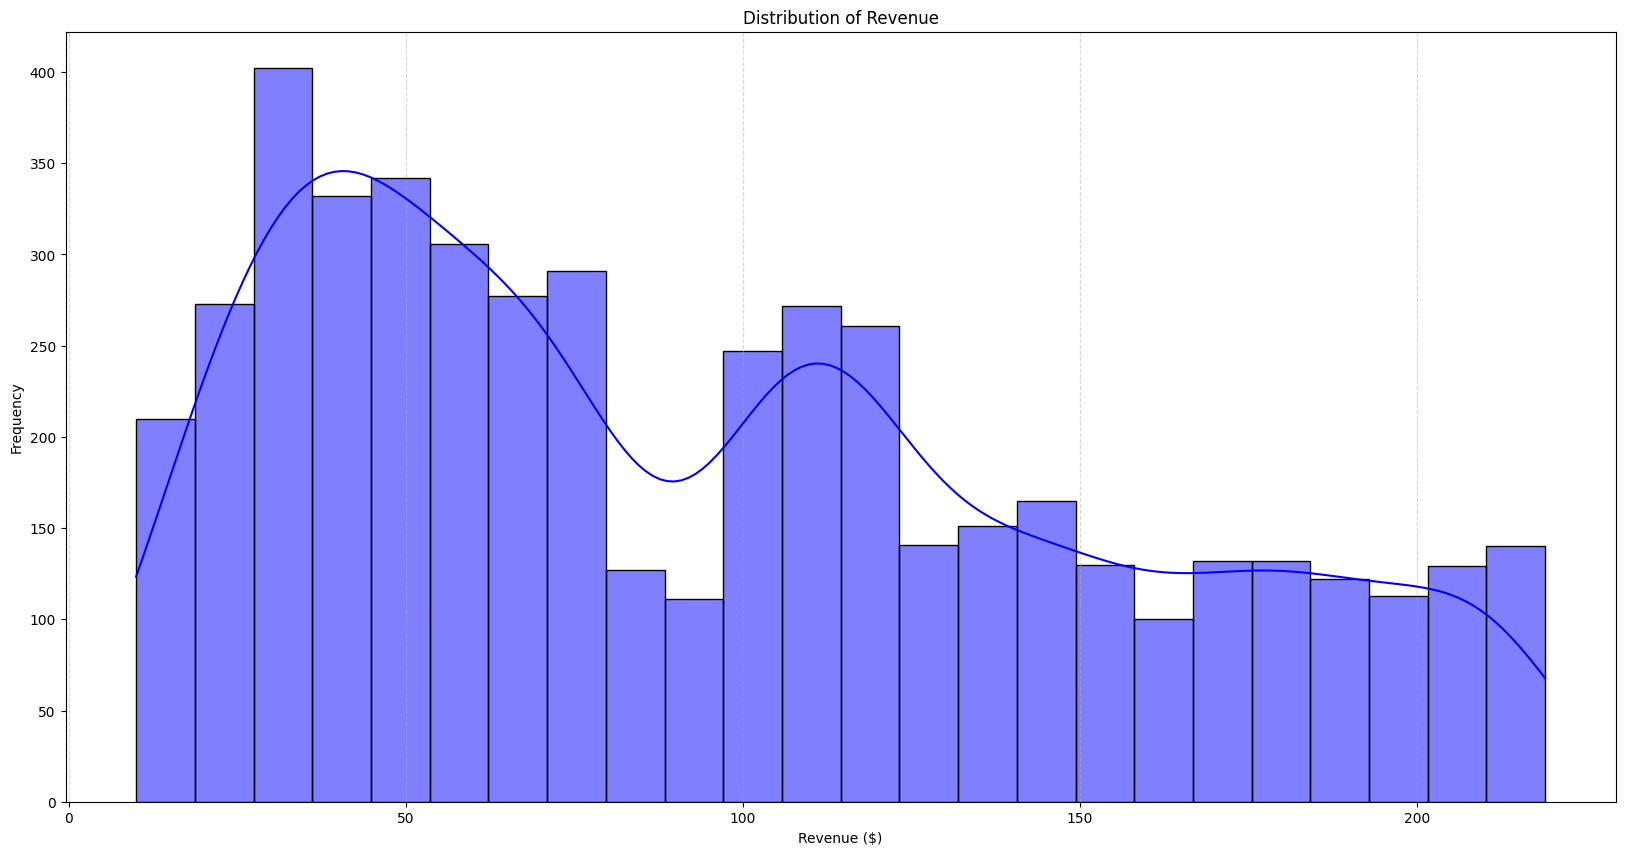

In [58]:
plt.figure(figsize=(20, 10))
sns.histplot(data=df['revenue'], bins=24, kde=True, color='blue')

plt.title('Distribution of Revenue')
plt.xlabel('Revenue ($)')
plt.ylabel('Frequency')
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.show

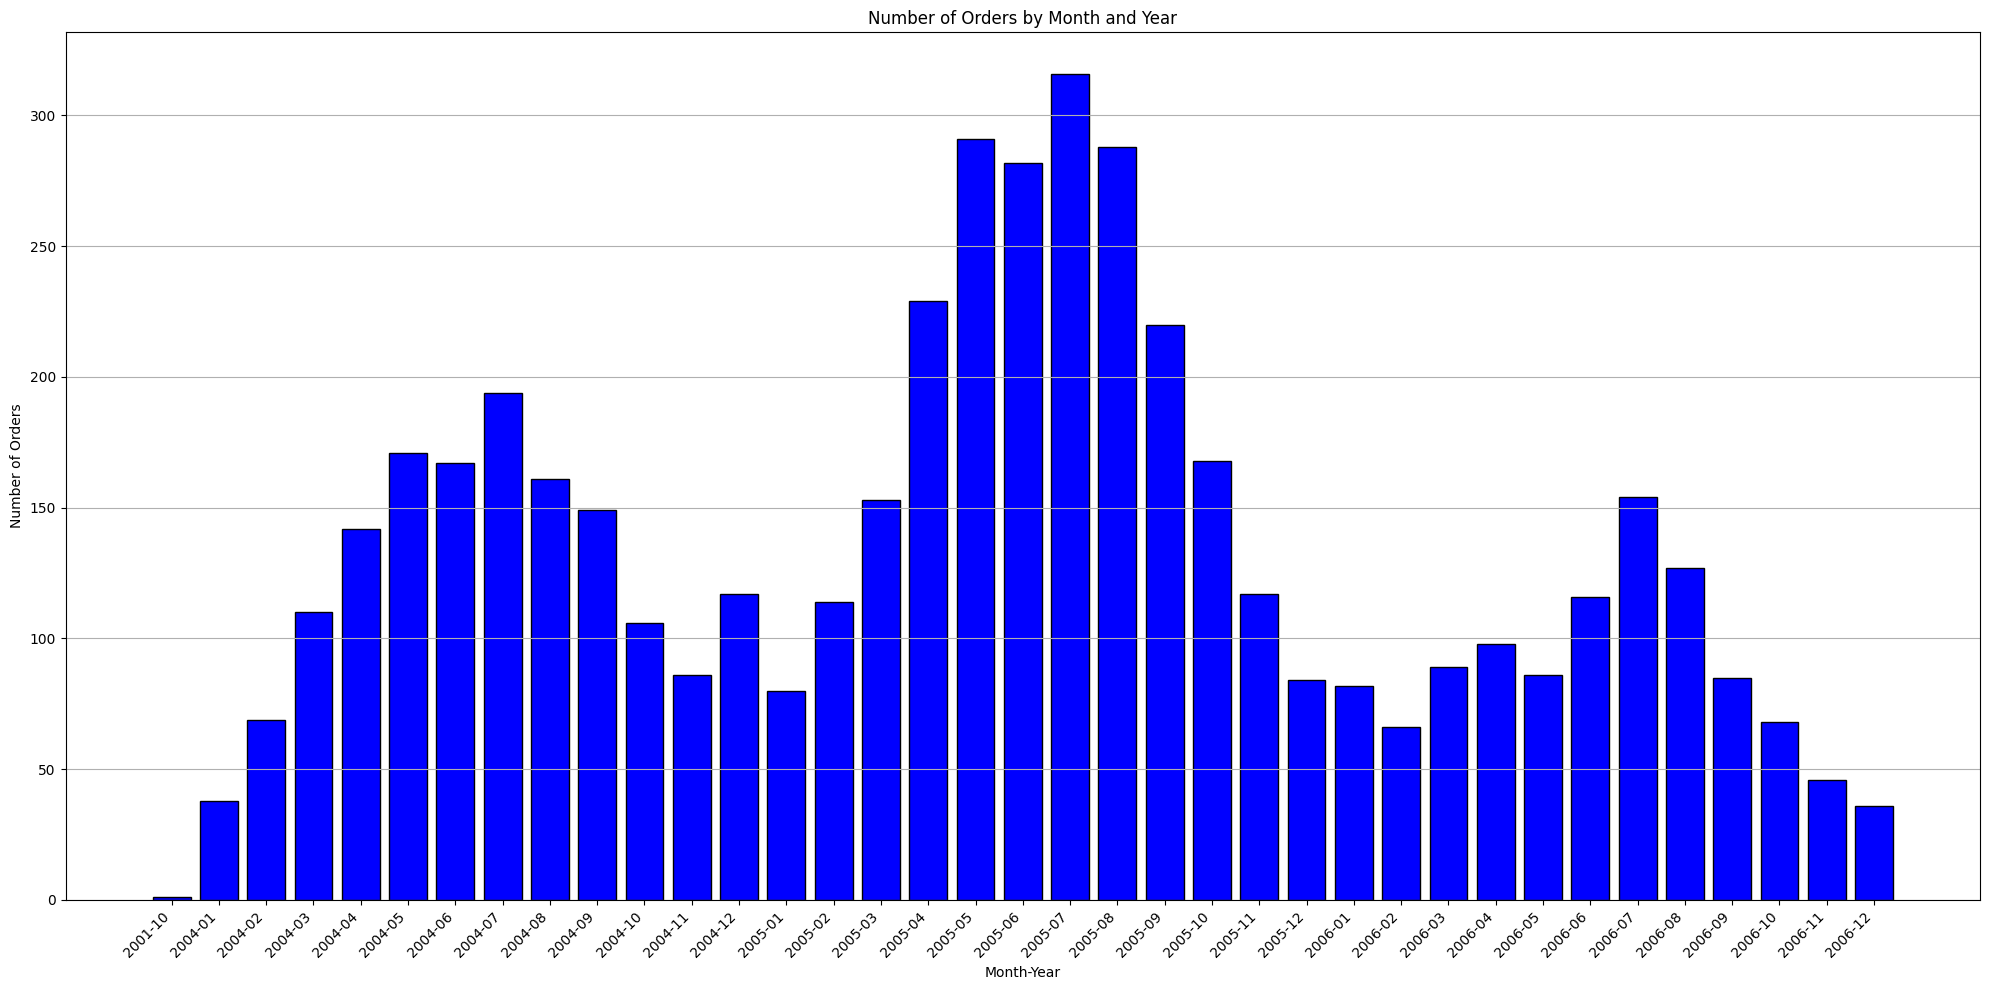

In [59]:

# Convert 'order_date' to datetime
df['order_date'] = pd.to_datetime(df['order_date'])

# Extract year and month name
df['Year'] = df['order_date'].dt.year
df['Month'] = df['order_date'].dt.strftime('%b')  # abbreviated month name
df['Year-Month'] = df['order_date'].dt.to_period('M').astype(str)  # e.g. "2023-04"

# Group by Year-Month and count orders
monthly_orders = df.groupby('Year-Month').size().reset_index(name='Order Count')

# Convert 'Year-Month' back to datetime for sorting and plotting
monthly_orders['Year-Month'] = pd.to_datetime(monthly_orders['Year-Month'])
monthly_orders = monthly_orders.sort_values('Year-Month')

# Plot bar chart
plt.figure(figsize=(20, 10))
plt.bar(monthly_orders['Year-Month'].dt.strftime('%Y-%m'), monthly_orders['Order Count'],
        color='blue', edgecolor='black')

plt.title('Number of Orders by Month and Year')
plt.xlabel('Month-Year')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y')
plt.show()





## 1. Data Preparation

### Checking for the missing value

In [60]:
# Check if there are any missing values
if df.isnull().values.any():
    print("DataFrame has missing values")
else:
    print("No missing values in DataFrame")


No missing values in DataFrame


### Convert order_date to datetime format

In [61]:
df['order_date'] = pd.to_datetime(df['order_date'])


### Define the reference date 

In [62]:
reference_date = df['order_date'].max()
print(f"Reference date: {reference_date}")

Reference date: 2006-12-30 00:00:00


## 2. Compute RFM metrics

In [63]:
rfm_df = df.groupby('customer_id').agg(
    Recency=('order_date', lambda x: (reference_date - x.max()).days),
    Frequency=('customer_id', 'count'),
    Monetary=('revenue', 'sum')
).reset_index()
print("\nFirst 10 rows of RFM metrics:")
print(rfm_df.head(10))


First 10 rows of RFM metrics:
      customer_id  Recency  Frequency  Monetary
0  Abbey O'Reilly      204          6       472
1      Add Senger      139          3       340
2      Aden Lesch      193          4       405
3     Aden Murphy       97          7       596
4  Admiral Senger      131          5       448
5  Agness O'Keefe       89          9       843
6   Aileen Barton       83          9       763
7  Ailene Hermann      280          8       699
8   Aiyanna Bruen      245          4       157
9   Akeelah Walsh      159          7       779


### Assign scores based on quintiles

In [64]:
rfm_df['R_Score'] = pd.qcut(rfm_df['Recency'], q=5, labels=[5, 4, 3, 2, 1])
rfm_df['F_Score'] = pd.qcut(rfm_df['Frequency'], q=5, labels=[1, 2, 3, 4, 5])
rfm_df['M_Score'] = pd.qcut(rfm_df['Monetary'], q=5, labels=[1, 2, 3, 4, 5])
print("\nFirst 10 rows with RFM scores:")
print(rfm_df.head(10))


First 10 rows with RFM scores:
      customer_id  Recency  Frequency  Monetary R_Score F_Score M_Score
0  Abbey O'Reilly      204          6       472       3       4       3
1      Add Senger      139          3       340       4       1       2
2      Aden Lesch      193          4       405       3       2       3
3     Aden Murphy       97          7       596       5       4       4
4  Admiral Senger      131          5       448       4       3       3
5  Agness O'Keefe       89          9       843       5       5       5
6   Aileen Barton       83          9       763       5       5       5
7  Ailene Hermann      280          8       699       3       5       5
8   Aiyanna Bruen      245          4       157       3       2       1
9   Akeelah Walsh      159          7       779       4       4       5


### Define customer segmentation function

In [65]:
def classify_customer(row):
    r, f, m = int(row['R_Score']), int(row['F_Score']), int(row['M_Score'])
    
    if r >= 4 and f >= 4 and m >= 4:
        return "Champions"
    elif 2 <= r <= 4 and 3 <= f <= 4 and 4 <= m <= 5:
        return "Loyal Customers"
    elif 3 <= r <= 5 and 1 <= f <= 3 and 1 <= m <= 3:
        return "Potential Loyalist"
    elif r >= 4 and f < 2 and m < 2:
        return "New Customers"
    elif 3 <= r <= 4 and f < 2 and m < 2:
        return "Promising"
    elif 3 <= r <= 4 and 3 <= f <= 4 and 3 <= m <= 4:
        return "Need Attention"
    elif 2 <= r <= 3 and f < 3 and m < 3:
        return "About To Sleep"
    elif r < 3 and 2 <= f <= 5 and 2 <= m <= 5:
        return "At Risk"
    elif r < 2 and f >= 4 and m >= 4:
        return "Can't Lose Them"
    elif 2 <= r <= 3 and 2 <= f <= 3 and 2 <= m <= 3:
        return "Hibernating"
    elif r < 2 and f < 2 and m < 2:
        return "Lost"
    else:
        return "Other"

### Apply segmentation

In [66]:
rfm_df['Segment'] = rfm_df.apply(classify_customer, axis=1)
print("\nFirst 5 rows with segments:")
print(rfm_df.head(5))


First 5 rows with segments:
      customer_id  Recency  Frequency  Monetary R_Score F_Score M_Score  \
0  Abbey O'Reilly      204          6       472       3       4       3   
1      Add Senger      139          3       340       4       1       2   
2      Aden Lesch      193          4       405       3       2       3   
3     Aden Murphy       97          7       596       5       4       4   
4  Admiral Senger      131          5       448       4       3       3   

              Segment  
0      Need Attention  
1  Potential Loyalist  
2  Potential Loyalist  
3           Champions  
4  Potential Loyalist  


### Calculate RFM_Score

In [67]:
# Convert integer scores to string and calculate RFM_Score
rfm_df['RFM_Score'] = rfm_df['R_Score'].astype(str) + rfm_df['F_Score'].astype(str) + rfm_df['M_Score'].astype(str)

# Display updated DataFrame
print(rfm_df[['customer_id', 'Recency', 'Frequency', 'Monetary', 'R_Score', 'F_Score', 'M_Score', 'RFM_Score', 'Segment']].head())


      customer_id  Recency  Frequency  Monetary R_Score F_Score M_Score  \
0  Abbey O'Reilly      204          6       472       3       4       3   
1      Add Senger      139          3       340       4       1       2   
2      Aden Lesch      193          4       405       3       2       3   
3     Aden Murphy       97          7       596       5       4       4   
4  Admiral Senger      131          5       448       4       3       3   

  RFM_Score             Segment  
0       343      Need Attention  
1       412  Potential Loyalist  
2       323  Potential Loyalist  
3       544           Champions  
4       433  Potential Loyalist  


### Create a binned monetary column for distribution analysis

In [68]:
rfm_df['Monetary_Binned'] = pd.qcut(rfm_df['Monetary'], q=5, labels=[1, 2, 3, 4, 5])
print(rfm_df.head(5))

      customer_id  Recency  Frequency  Monetary R_Score F_Score M_Score  \
0  Abbey O'Reilly      204          6       472       3       4       3   
1      Add Senger      139          3       340       4       1       2   
2      Aden Lesch      193          4       405       3       2       3   
3     Aden Murphy       97          7       596       5       4       4   
4  Admiral Senger      131          5       448       4       3       3   

              Segment RFM_Score Monetary_Binned  
0      Need Attention       343               3  
1  Potential Loyalist       412               2  
2  Potential Loyalist       323               3  
3           Champions       544               4  
4  Potential Loyalist       433               3  


In [ ]:
# ---- Existing chart code ends here ----
plt.show()

# ---- Plot Average RFM Score by Segment below ----

# Make sure RFM_score is numeric
rfm_df['RFM_score'] = rfm_df['RFM_score'].astype(int)

# Calculate average RFM Score per Segment
rfm_score_by_segment = rfm_df.groupby('Segment')['RFM_score'].mean().reset_index()

# Sort to match segment order
rfm_score_by_segment = rfm_score_by_segment.set_index("Segment").loc[correct_order].reset_index()

# Map the same colors
rfm_score_colors = [color_dict.get(seg, '#D3D3D3') for seg in rfm_score_by_segment['Segment']]

# Plot RFM Score chart
plt.figure(figsize=(10, 6))
sns.barplot(
    x='RFM_score',
    y='Segment',
    data=rfm_score_by_segment,
    palette=rfm_score_colors,
    order=correct_order
)

plt.xlabel('Average RFM Score')
plt.ylabel('Segment')
plt.title('Average RFM Score by Segment')

# Reuse same legend
plt.legend(handles=legend_patches, title="Segment Categories", loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()


### Aggregate median RFM values per segment

In [69]:
segment_metrics = rfm_df.groupby('Segment').agg(
    Median_Recency=('Recency', 'median'),
    Median_Frequency=('Frequency', 'median'),
    Median_Monetary=('Monetary', 'median')
).reset_index()

## 3. Visualizations

### Customers by Orders Distribution

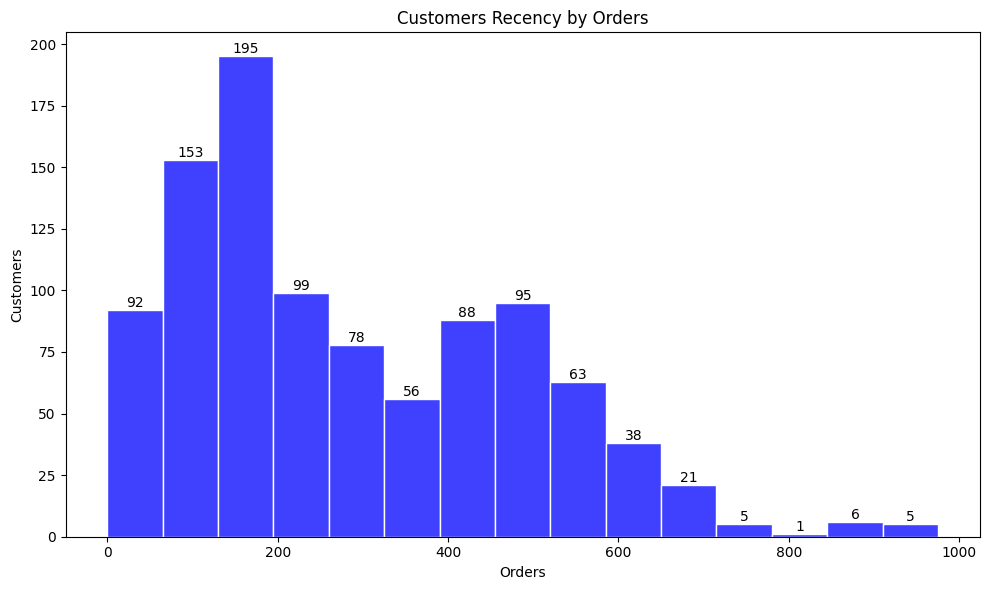

In [70]:
plt.figure(figsize=(10, 6))
# Create the histogram with specified bins
hist = sns.histplot(rfm_df['Recency'], bins=15, kde=False, color='blue', edgecolor='white')

# Get the counts from the histogram
counts = []
for p in hist.patches:
    counts.append(int(p.get_height()))

# Add text labels on top of each bar
for i, p in enumerate(hist.patches):
    # Display if there's a non-zero count
    if counts[i] > 0:  
        hist.annotate(f'{counts[i]}', 
                     (p.get_x() + p.get_width()/2., p.get_height()),
                     ha='center', va='bottom')

plt.xlabel("Orders")
plt.ylabel("Customers")
plt.title("Customers Recency by Orders")
plt.tight_layout()
plt.show()

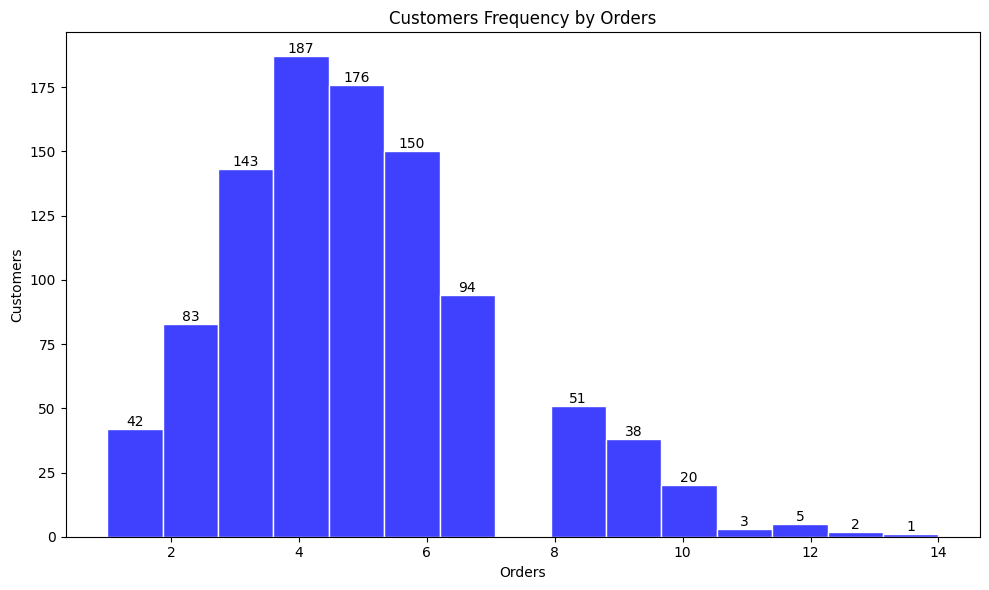

In [71]:
plt.figure(figsize=(10, 6))
# Create the histogram with specified bins
hist = sns.histplot(rfm_df['Frequency'], bins=15, kde=False, color='blue', edgecolor='white')

# Get the counts from the histogram
counts = []
for p in hist.patches:
    counts.append(int(p.get_height()))

# Add text labels on top of each bar
for i, p in enumerate(hist.patches):
    # Display if there's a non-zero count
    if counts[i] > 0:  
        hist.annotate(f'{counts[i]}', 
                     (p.get_x() + p.get_width()/2., p.get_height()),
                     ha='center', va='bottom')

plt.xlabel("Orders")
plt.ylabel("Customers")
plt.title("Customers Frequency by Orders")
plt.tight_layout()
plt.show()

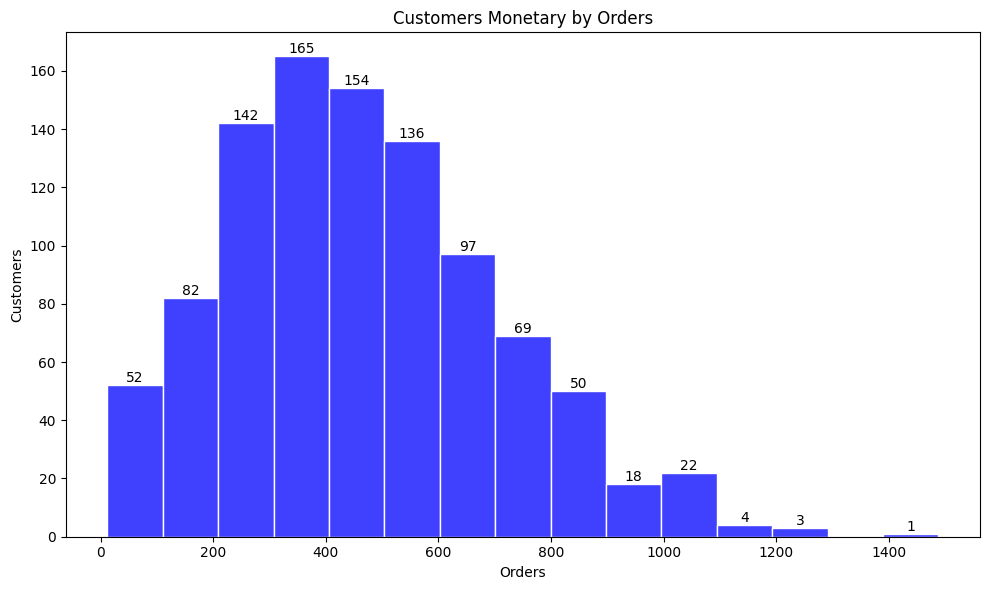

In [72]:
plt.figure(figsize=(10, 6))
# Create the histogram with specified bins
hist = sns.histplot(rfm_df['Monetary'], bins=15, kde=False, color='blue', edgecolor='white')

# Get the counts from the histogram
counts = []
for p in hist.patches:
    counts.append(int(p.get_height()))

# Add text labels on top of each bar
for i, p in enumerate(hist.patches):
    # Display if there's a non-zero count
    if counts[i] > 0:  
        hist.annotate(f'{counts[i]}', 
                     (p.get_x() + p.get_width()/2., p.get_height()),
                     ha='center', va='bottom')

plt.xlabel("Orders")
plt.ylabel("Customers")
plt.title("Customers Monetary by Orders")
plt.tight_layout()
plt.show()

### RFM Variable Histograms

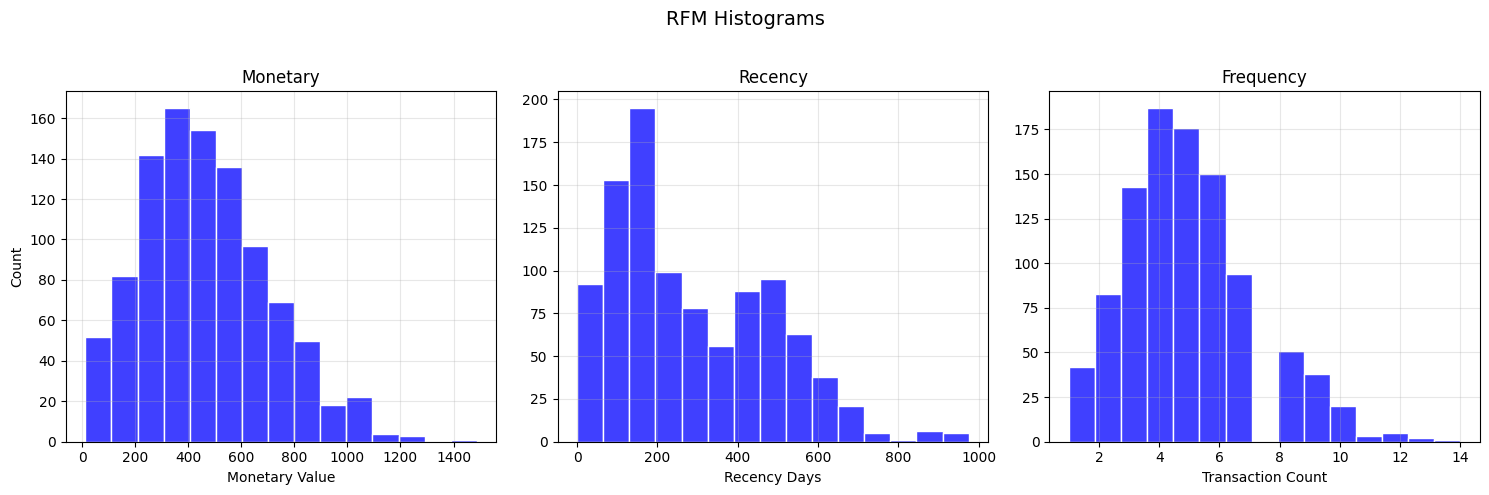

In [73]:
# Create RFM histograms 
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Monetary histogram
sns.histplot(rfm_df['Monetary'], bins=15, kde=False, ax=axes[0], color='blue', edgecolor='white')
axes[0].set_title("Monetary")
axes[0].set_xlabel("Monetary Value")
axes[0].set_ylabel("Count")
axes[0].grid(True, alpha=0.3)

# Recency histogram
sns.histplot(rfm_df['Recency'], bins=15, kde=False, ax=axes[1], color='blue', edgecolor='white')
axes[1].set_title("Recency")
axes[1].set_xlabel("Recency Days")
axes[1].set_ylabel("")  
axes[1].grid(True, alpha=0.3)

# Frequency histogram
sns.histplot(rfm_df['Frequency'], bins=15, kde=False, ax=axes[2], color='blue', edgecolor='white')
axes[2].set_title("Frequency")
axes[2].set_xlabel("Transaction Count")
axes[2].set_ylabel("")  
axes[2].grid(True, alpha=0.3)

# Add shared title and adjust layout
plt.suptitle("RFM Histograms", fontsize=14, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])  
plt.show()

### Customer Segments Treemap

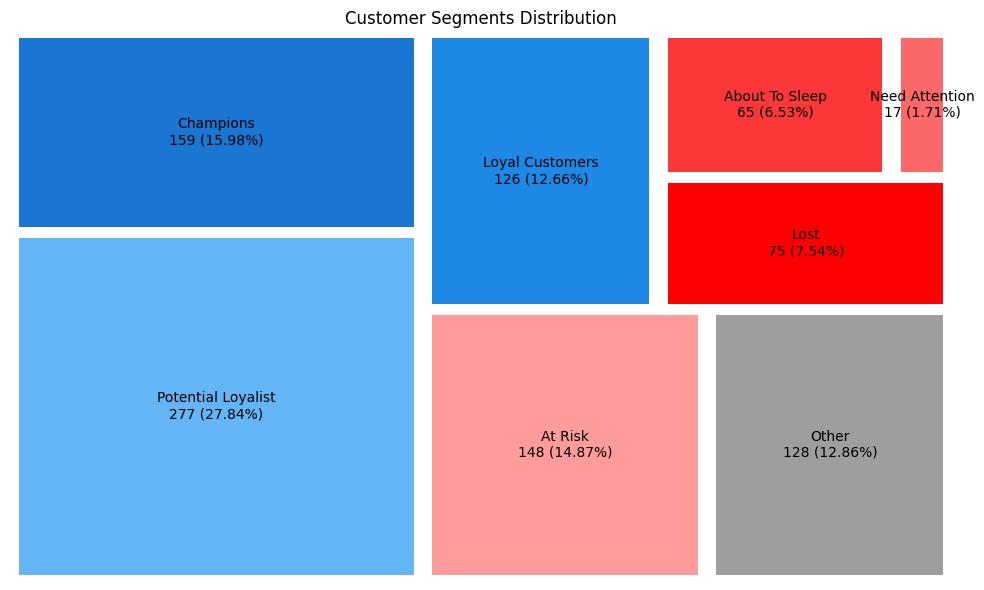

In [74]:
plt.figure(figsize=(10, 6))
# Get segment counts and percentages
segment_counts = rfm_df['Segment'].value_counts()
total_customers = len(rfm_df)
segment_percentages = segment_counts / total_customers * 100

# Create a dataframe for squarify
segments_df = pd.DataFrame({
    'Segment': segment_counts.index,
    'Count': segment_counts.values,
    'Percentage': segment_percentages.values
})

# Sort by count for better visualization
segments_df = segments_df.sort_values('Count', ascending=False)

# Create labels with count and percentage
segments_df['Label'] = segments_df.apply(
    lambda x: f"{x['Segment']}\n{int(x['Count'])} ({x['Percentage']:.2f}%)", axis=1)

# Define colors for each segment - replaced green tones with blue ones
colors = {
    'Champions': '#1976D2',           
    'Loyal Customers': '#1E88E5',     
    'Potential Loyalist': '#64B5F6',  
    'New Customers': '#7E57C2',       
    'Promising': '#EC407A',
    'Need Attention': '#fc6767',     
    'About To Sleep': '#fc3737',     
    'At Risk': '#ff9b9b',            
    "Can't Lose Them": '#C0CA33',     
    'Hibernating': '#5C6BC0',        
    'Lost': '#ff0000',                
    'Other': '#9E9E9E'               
}



# Create color list in the same order as segments
segment_colors = [colors.get(segment, '#BDBDBD') for segment in segments_df['Segment']]

# Create the treemap
import squarify
squarify.plot(sizes=segments_df['Count'], 
              label=segments_df['Label'],
              color=segment_colors,
              alpha=1.0,
              pad=True)

plt.axis('off')
plt.title('Customer Segments Distribution')
plt.tight_layout()
plt.show()

/var/folders/1j/g0dbmj351815t2_1w_xl3jrm0000gn/T/ipykernel_1594/3824061301.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


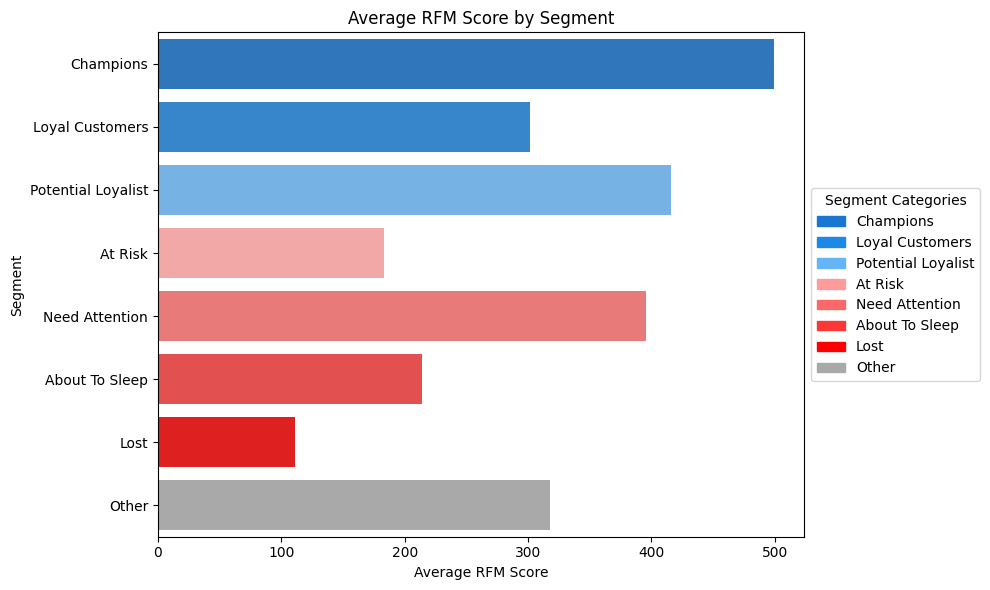

In [83]:
# Convert RFM_Score to integer for averaging
rfm_df['RFM_Score'] = rfm_df['RFM_Score'].astype(int)

# Define the correct segment order and colors again (if not already in scope)
correct_order = [
    "Champions", "Loyal Customers", "Potential Loyalist",
    "At Risk", "Need Attention", "About To Sleep", "Lost",
    "Other"
]

# Define segments for color coding
best_segments = ["Champions", "Loyal Customers", "Potential Loyalist"]
bad_segments = ["At Risk", "Need Attention", "About To Sleep", "Lost"]
other_segments = ["Other"]

# Define colors
blue_shades = ['#1976D2', '#1E88E5', '#64B5F6']  # Best
red_shades = ['#ff9b9b', '#fc6767', '#fc3737', '#ff0000']  # Bad
gray_shades = ['#A9A9A9']  # Other

# Build color mapping
color_dict = {}
for seg in correct_order:
    if seg in best_segments:
        idx = best_segments.index(seg)
        color_dict[seg] = blue_shades[idx]
    elif seg in bad_segments:
        idx = bad_segments.index(seg)
        color_dict[seg] = red_shades[idx]
    elif seg in other_segments:
        color_dict[seg] = gray_shades[0]
    else:
        color_dict[seg] = '#D3D3D3'

# Group by Segment and calculate average RFM Score
rfm_score_by_segment = rfm_df.groupby('Segment')['RFM_Score'].mean().reset_index()

# Sort according to desired order
rfm_score_by_segment = rfm_score_by_segment.set_index("Segment").loc[
    [s for s in correct_order if s in rfm_score_by_segment['Segment'].values]
].reset_index()

# Assign colors for the plot
colors = [color_dict.get(seg, '#D3D3D3') for seg in rfm_score_by_segment['Segment']]

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x='RFM_Score',
    y='Segment',
    data=rfm_score_by_segment,
    palette=colors,
    order=correct_order
)

plt.xlabel('Average RFM Score')
plt.ylabel('Segment')
plt.title('Average RFM Score by Segment')

# Legend
legend_patches = [mpatches.Patch(color=c, label=s) for s, c in color_dict.items()]
plt.legend(handles=legend_patches, title="Segment Categories", loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()


/var/folders/1j/g0dbmj351815t2_1w_xl3jrm0000gn/T/ipykernel_1594/3053260515.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


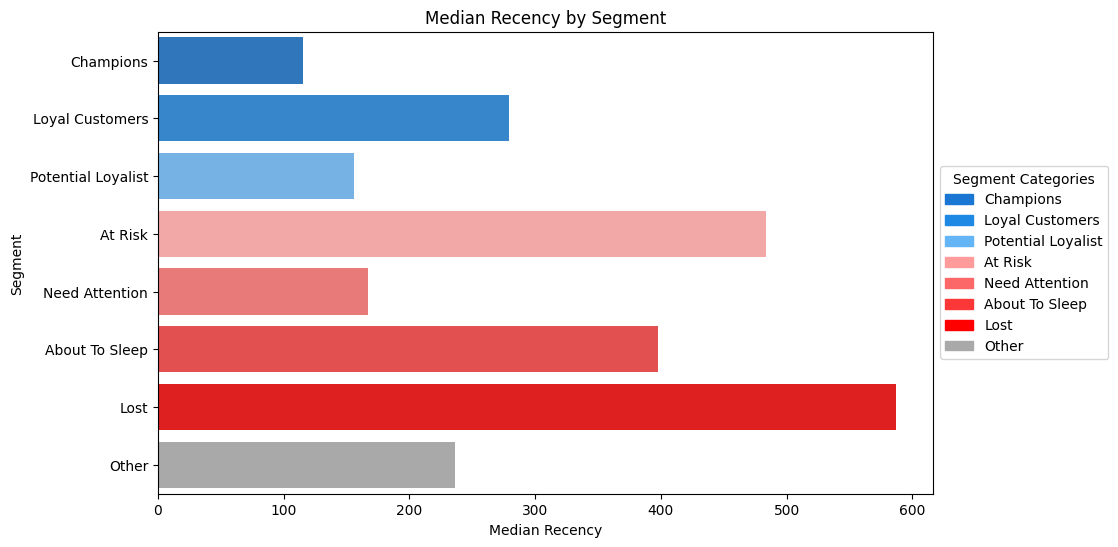

In [75]:
# Define new correct order
correct_order = [
    "Champions", "Loyal Customers", "Potential Loyalist",   # Good Segments
    "At Risk", "Need Attention", "About To Sleep", "Lost",  # Bad Segments
    "Other"  # Other Segments
]

# Ensure DataFrame is sorted in the new order
segment_metrics_sorted = segment_metrics.set_index("Segment").loc[correct_order].reset_index()

# Define ordered segmentation based on performance
best_segments = ["Champions",  "Loyal Customers", "Potential Loyalist"]
bad_segments = ["Need Attention", "About To Sleep", "At Risk", "Lost"]
other_segments = ["Other"]

colors = []

# Updated color gradient: using blues instead of greens
blue_shades = ['#1976D2', '#1E88E5', '#64B5F6'] 
red_shades = ['#fc6767', '#fc3737', '#ff9b9b', '#ff0000']
gray_shades = ['#A9A9A9', '#D3D3D3']

# Assign colors dynamically
color_dict = {}
for segment in segment_metrics_sorted['Segment']:
    if segment in best_segments:
        idx = best_segments.index(segment)
        color = blue_shades[idx]
        colors.append(color)
        color_dict[segment] = color
    elif segment in bad_segments:
        idx = bad_segments.index(segment)
        color = red_shades[idx]
        colors.append(color)
        color_dict[segment] = color
    elif segment in other_segments:
        idx = other_segments.index(segment)
        color = gray_shades[idx]
        colors.append(color)
        color_dict[segment] = color
    else:
        colors.append('#A9A9A9')  # Default gray

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Median_Recency', 
    y='Segment', 
    data=segment_metrics_sorted, 
    palette=colors,
    order=correct_order
)

plt.xlabel('Median Recency')
plt.ylabel('Segment')
plt.title('Median Recency by Segment')

# Create legend patches
legend_patches = [mpatches.Patch(color=color, label=segment) for segment, color in color_dict.items()]

# Place legend on the right-hand side
plt.legend(handles=legend_patches, title="Segment Categories", loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()


### Segment Analysis - Bar Charts

/var/folders/1j/g0dbmj351815t2_1w_xl3jrm0000gn/T/ipykernel_1594/3476278850.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


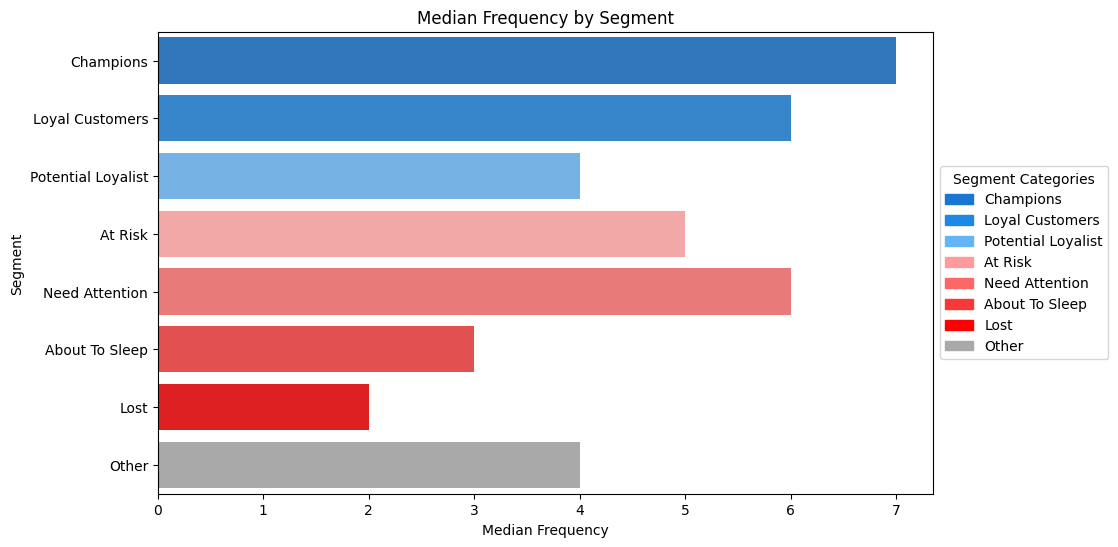

In [76]:
# Define correct order (Good Segments at the Top, Bad at the Bottom, Others Last)
correct_order = [
    "Champions", "Loyal Customers", "Potential Loyalist", 
    "At Risk", "Need Attention", "About To Sleep", "Lost", 
    "Other"
]

# Ensure DataFrame is sorted in the correct order
segment_metrics_sorted = segment_metrics.set_index("Segment").loc[correct_order].reset_index()

# Define segmentation groups
best_segments = ["Champions", "Loyal Customers", "Potential Loyalist"]
bad_segments = ["At Risk", "Need Attention", "About To Sleep", "Lost"]
other_segments = ["Other"]

colors = []

# Replace green shades with blue
blue_shades = ['#1976D2', '#1E88E5', '#64B5F6']  # Best Segments (Dark Blue → Light Blue)
red_shades = ['#ff9b9b', '#fc6767', '#fc3737', '#ff0000']  # Worst Segments (Light Red → Dark Red)
gray_shades = ['#A9A9A9']  # Neutral Segments (Other)

# Assign colors dynamically based on segment type
color_dict = {}
for segment in segment_metrics_sorted['Segment']:
    if segment in best_segments:
        idx = best_segments.index(segment)
        color = blue_shades[idx]
    elif segment in bad_segments:
        idx = bad_segments.index(segment)
        color = red_shades[idx]
    elif segment in other_segments:
        color = gray_shades[0]  # Assign gray to "Other"
    else:
        color = "#D3D3D3"  # Default gray

    colors.append(color)
    color_dict[segment] = color  # Store for legend

# Plot Bar Chart
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Median_Frequency', 
    y='Segment', 
    data=segment_metrics_sorted, 
    palette=colors, 
    order=correct_order
)

plt.xlabel('Median Frequency')
plt.ylabel('Segment')
plt.title('Median Frequency by Segment')

# Create legend patches
legend_patches = [mpatches.Patch(color=color, label=segment) for segment, color in color_dict.items()]

# Place legend on the right-hand side for clarity
plt.legend(handles=legend_patches, title="Segment Categories", loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()


/var/folders/1j/g0dbmj351815t2_1w_xl3jrm0000gn/T/ipykernel_1594/1298059786.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


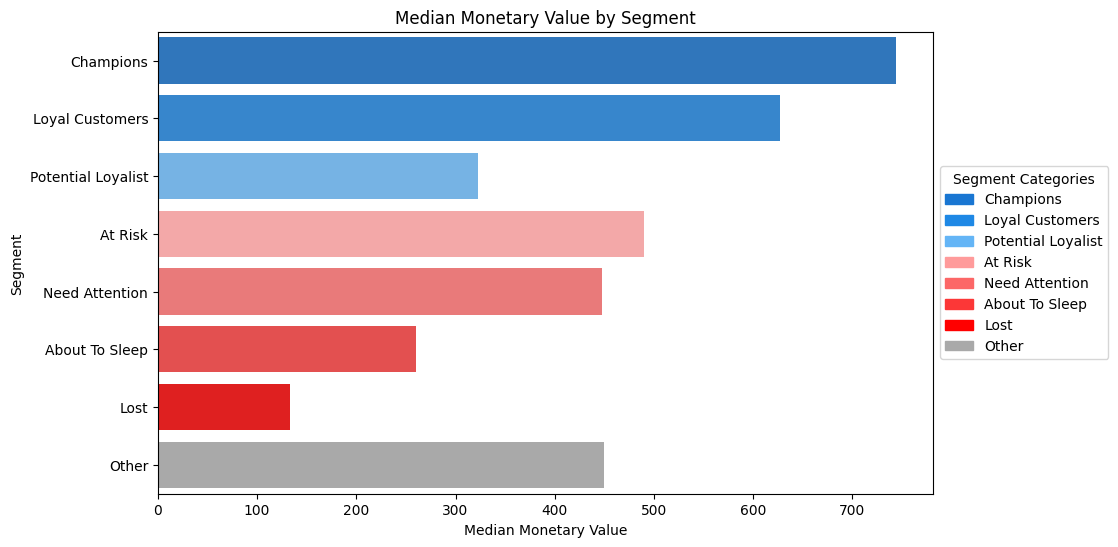

In [ ]:
# Define correct order (Ensuring consistency with previous charts)
correct_order = [
    "Champions", "Loyal Customers", "Potential Loyalist",  # Good Segments
    "At Risk", "Need Attention", "About To Sleep", "Lost",  # Bad Segments
    "Other"  # Other Segments
]

# Ensure DataFrame is sorted in the correct order
segment_metrics_sorted = segment_metrics.set_index("Segment").loc[correct_order].reset_index()

# Define segmentation groups
best_segments = ["Champions", "Loyal Customers", "Potential Loyalist"]
bad_segments = ["At Risk", "Need Attention", "About To Sleep", "Lost"]
other_segments = ["Other"]
colors = []

# Replace green with blue
blue_shades = ['#1976D2', '#1E88E5', '#64B5F6']  # Best Segments (Dark → Light Blue)
red_shades = ['#ff9b9b', '#fc6767', '#fc3737', '#ff0000']  # Worst Segments (Light → Dark Red)
gray_shades = ['#A9A9A9']  # Neutral Segments (Other)

# Assign colors dynamically based on segment type
color_dict = {}
for segment in segment_metrics_sorted['Segment']:
    if segment in best_segments:
        idx = best_segments.index(segment)
        color = blue_shades[idx]
    elif segment in bad_segments:
        idx = bad_segments.index(segment)
        color = red_shades[idx]
    elif segment in other_segments:
        color = gray_shades[0]  # Assign gray to "Other"
    else:
        color = "#D3D3D3"  # Default gray

    colors.append(color)
    color_dict[segment] = color  # Store for legend

# Plot Bar Chart
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Median_Monetary', 
    y='Segment', 
    data=segment_metrics_sorted, 
    palette=colors, 
    order=correct_order
)

plt.xlabel('Median Monetary Value')
plt.ylabel('Segment')
plt.title('Median Monetary Value by Segment')

# Create legend patches
legend_patches = [mpatches.Patch(color=color, label=segment) for segment, color in color_dict.items()]

# Place legend on the right-hand side for consistency
plt.legend(handles=legend_patches, title="Segment Categories", loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()


### RFM Heatmap

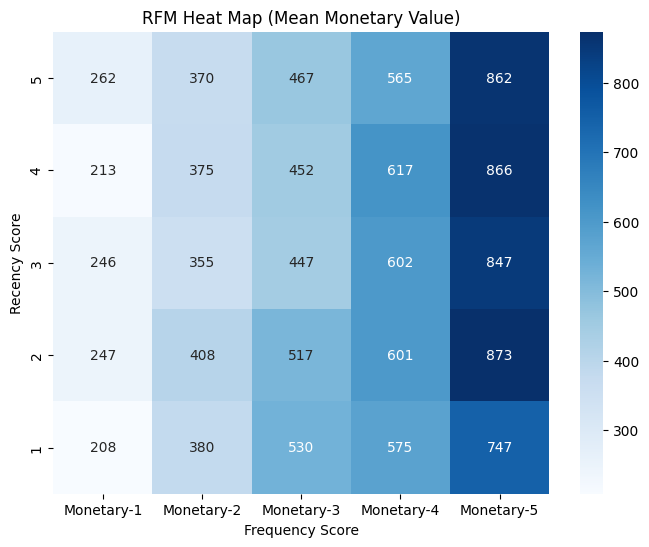

In [ ]:
rfm_heatmap = rfm_df.groupby(['R_Score', 'F_Score']).agg({'Monetary': 'mean'}).unstack()
plt.figure(figsize=(8, 6))
sns.heatmap(rfm_heatmap, cmap='Blues', annot=True, fmt=".0f")
plt.xlabel("Frequency Score")
plt.ylabel("Recency Score")
plt.title("RFM Heat Map (Mean Monetary Value)")
plt.show()


### Scatter Plots for RFM Relationships

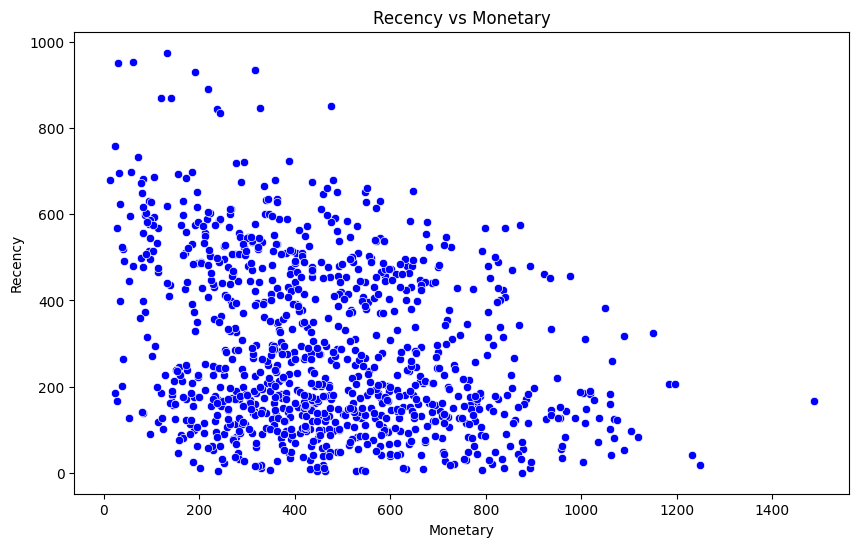

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=rfm_df['Monetary'], y=rfm_df['Recency'], color='blue')
plt.xlabel("Monetary")
plt.ylabel("Recency")
plt.title("Recency vs Monetary")
plt.show()

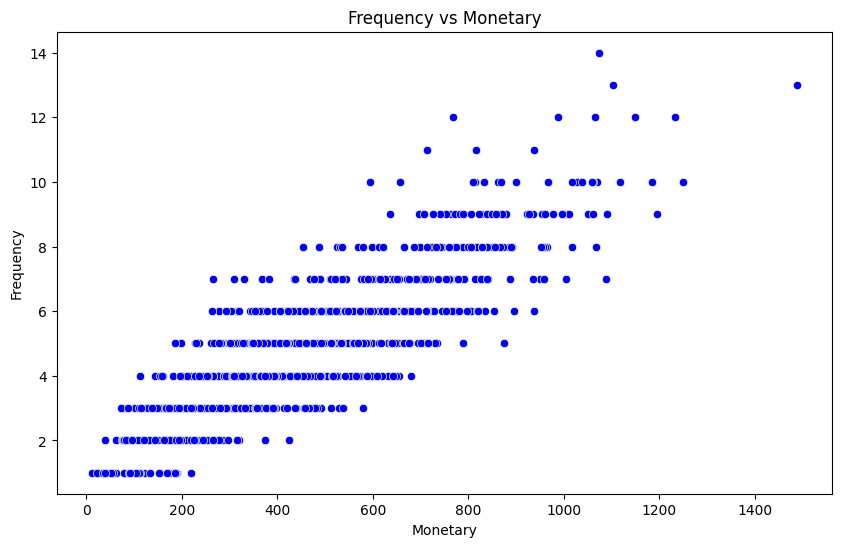

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=rfm_df['Monetary'], y=rfm_df['Frequency'], color='blue')
plt.xlabel("Monetary")
plt.ylabel("Frequency")
plt.title("Frequency vs Monetary")
plt.show()

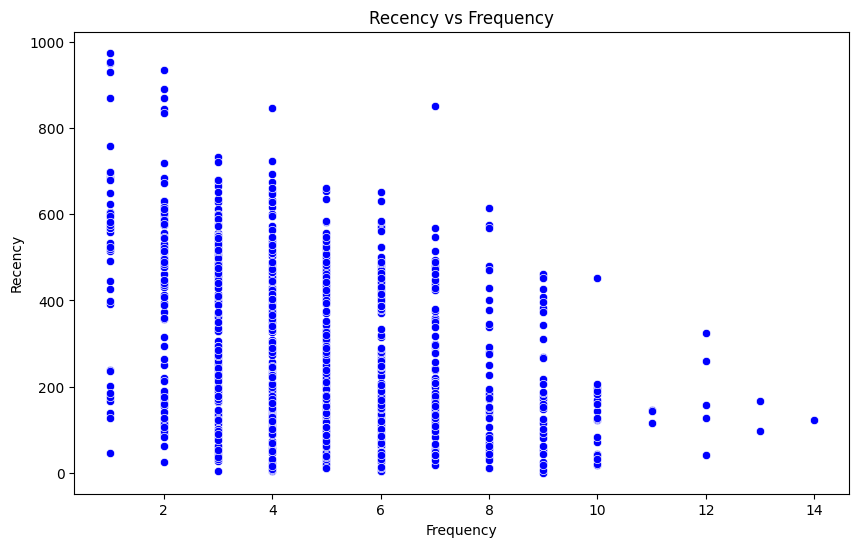

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=rfm_df['Frequency'], y=rfm_df['Recency'], color='blue')
plt.xlabel("Frequency")
plt.ylabel("Recency")
plt.title("Recency vs Frequency")
plt.show()

### Distribution of Monetary Scores per R and F Score

/Users/macbookpro/.pyenv/versions/3.9.6/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


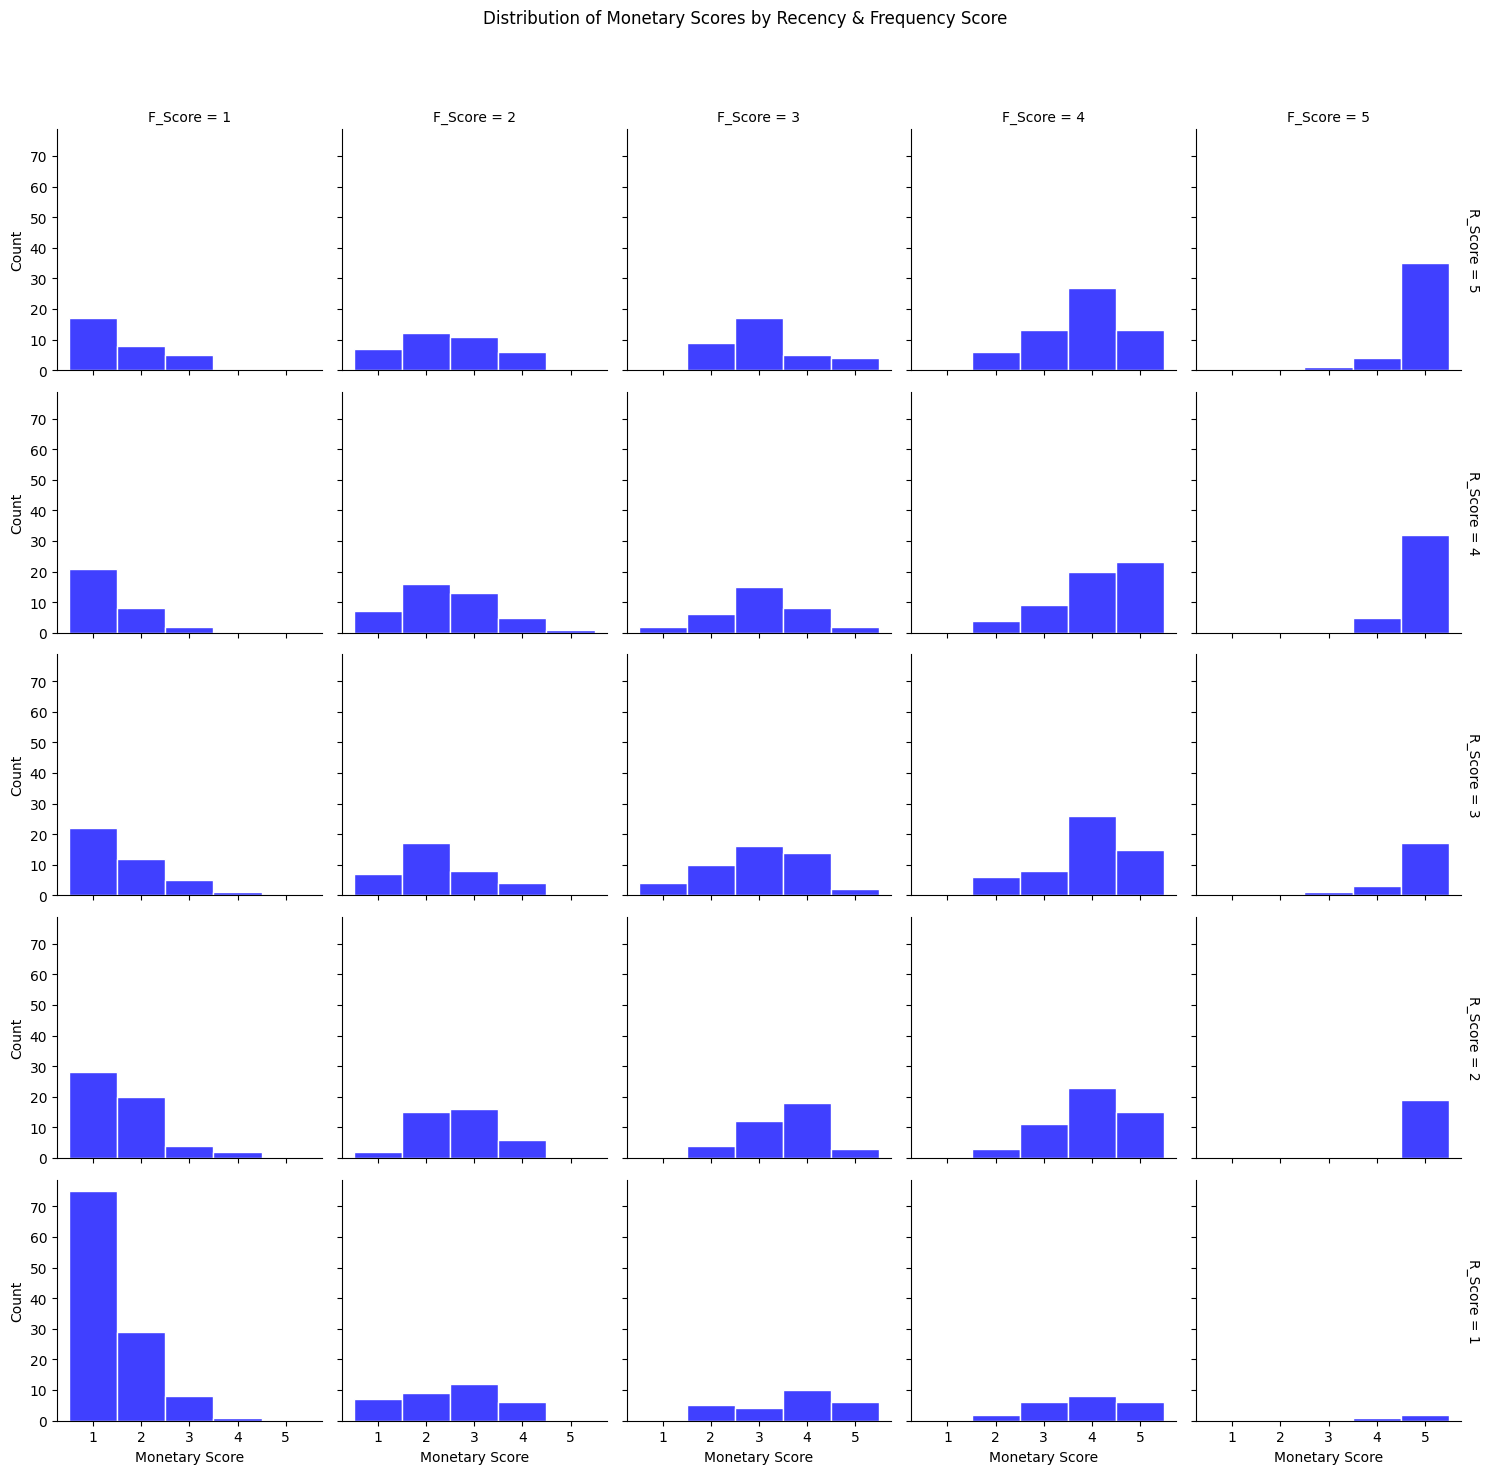

In [ ]:
g = sns.FacetGrid(rfm_df, row='R_Score', col='F_Score', margin_titles=True)
g.map_dataframe(sns.histplot, x='Monetary_Binned', color='blue', edgecolor='white')
g.set_axis_labels("Monetary Score", "Count")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Distribution of Monetary Scores by Recency & Frequency Score")
plt.show()